In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlalchemy as sqla
import csv
import matplotlib.pyplot as plt

## DATABASE CONNECTION

In [ ]:
DB_USER = "postgres"
DB_PASSWORD = "a"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "postgres"

connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Créer un moteur SQLAlchemy
engine = sqla.create_engine(connection_string)

try:
    with engine.connect() as connection:
        print("Connected to PostgreSQL successfully!")
except Exception as e:
    print(f"Error: {e}")

connection = engine.connect()

Connected to PostgreSQL successfully!


In [35]:
query = """
SELECT 
    td.id,
    td.departure_date,
    td.train_number,
    td.relation,
    td.train_service,
    td.ptcar_number,
    td.line_number_departure,
    td.real_time_arrival,
    td.real_time_departure,
    td.planned_time_arrival,
    td.planned_time_departure,
    td.delay_arrival,
    td.delay_departure,
    ptcar.id AS ptcar_id,         -- Ajout de l'identifiant du point de comptage
    ptcar.name AS name_travel,    -- Nom du point de comptage
    td.line_number_arrival,
    dep.name AS departure_station_name,
    arr.name AS arrival_station_name
FROM train_data td
JOIN STATIONS ptcar ON td.ptcar_name = ptcar.id
JOIN STATIONS dep ON td.station_departure = dep.id
JOIN STATIONS arr ON td.station_arrival = arr.id
WHERE td.station_arrival = '487'  
  AND td.station_departure = '159'  
ORDER BY td.id;
"""

line = pd.read_sql(sqla.text(query), connection)

line =line.drop(columns=['train_service', 'relation'])

print(line.head())




         id departure_date  train_number  ptcar_number line_number_departure  \
0  24603914     2014-12-14          2103            70                   162   
1  24603915     2014-12-14          2104            70                   162   
2  24603916     2014-12-14          2105            70                   162   
3  24603917     2014-12-14          2106            70                   162   
4  24603918     2014-12-14          2108           220                   0/3   

  real_time_arrival real_time_departure planned_time_arrival  \
0              None            06:32:31                 None   
1              None            07:30:12                 None   
2              None            08:30:14                 None   
3              None            09:32:41                 None   
4              None            08:45:07                 None   

  planned_time_departure  delay_arrival  delay_departure  ptcar_id  \
0               06:32:00            0.0             31.0        

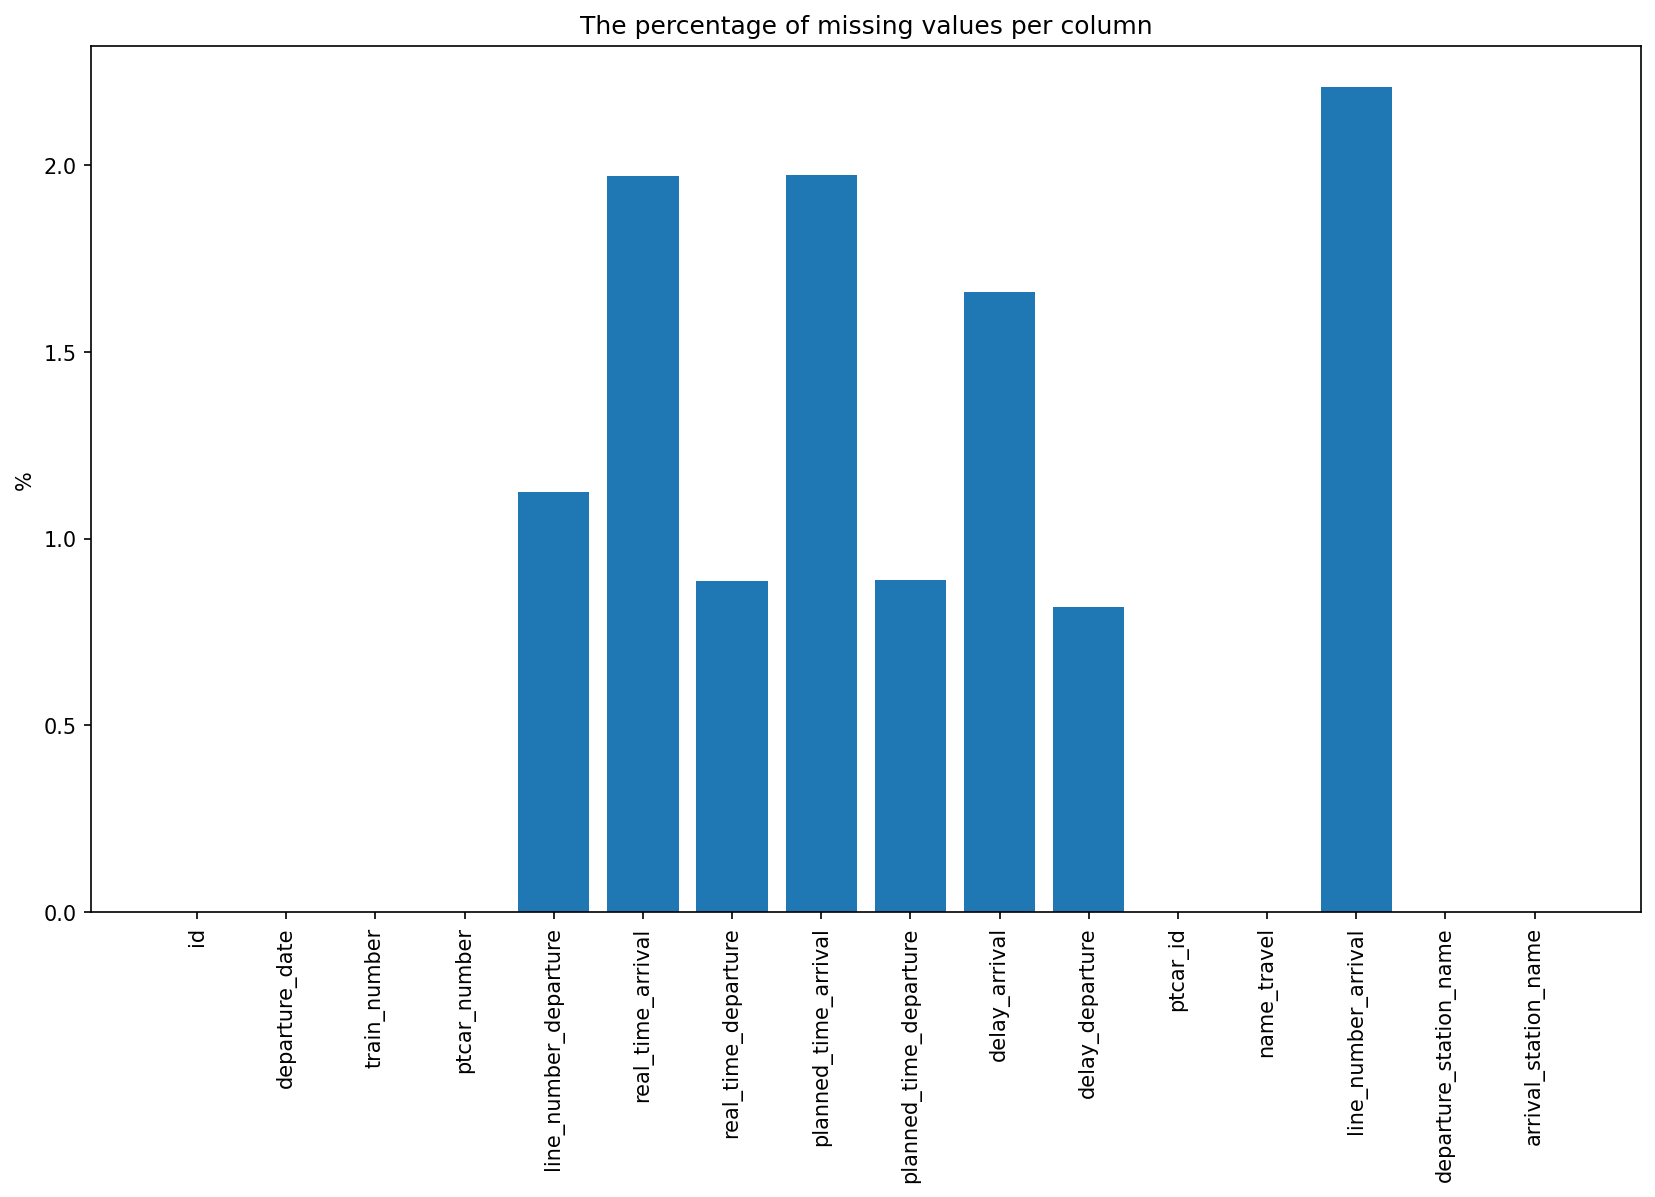

In [36]:
fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
ax.bar(line.columns, line.isna().sum() / line.shape[0] * 100)
plt.xticks(rotation=90)
plt.ylabel("%")
plt.title("The percentage of missing values per column")
plt.show()

In [37]:
print(line['ptcar_id'].unique())

[ 70 159 151 149 150 156 157 154 245 773 132 310 365 422 300 628 614 591
 540 118 178 235 281 480 108 642 624 623 557 558 384 199 559 645 195  73
 261 560 187 438 172 342 341  80 503 388 267 313 608 339 452 564 493 317
 704 757 646 331 209 794 575 415 416 237 740 352 445 362 593 690 601 264
  69 276  91 774 111 469 592 383 485 305 792 215  20 282 371  94 279 278
 309 168 598 106 263 754 319  77  75 527 583 143 589  95 501   5 100 327
 428 218 289 205 525 513 656 247 130 330 448 625 171 509 389 551 550 271
 262 256 632 170 196 253 426 752 726 727 465 260 474 176 177 192 180 434
 252   9 710  79 392 391 323 161  28 751 328 119 604 166 508  21 731 521
 515 421 780 672 681 437   2 234 207 454 633 668 659 661 663 655 664 662
 123 487 158 683 720 552 629 586 587 588 495 496 556 678 179  14 386  89
 703 374  12  11 340 355 231 259 257 680 596 406 405  18 724 526 368 241
 612 627 626 190 325 709 125  88 517 494  17 660 489 753 232 366 361 129
 314 315 779 324 785 174 658]


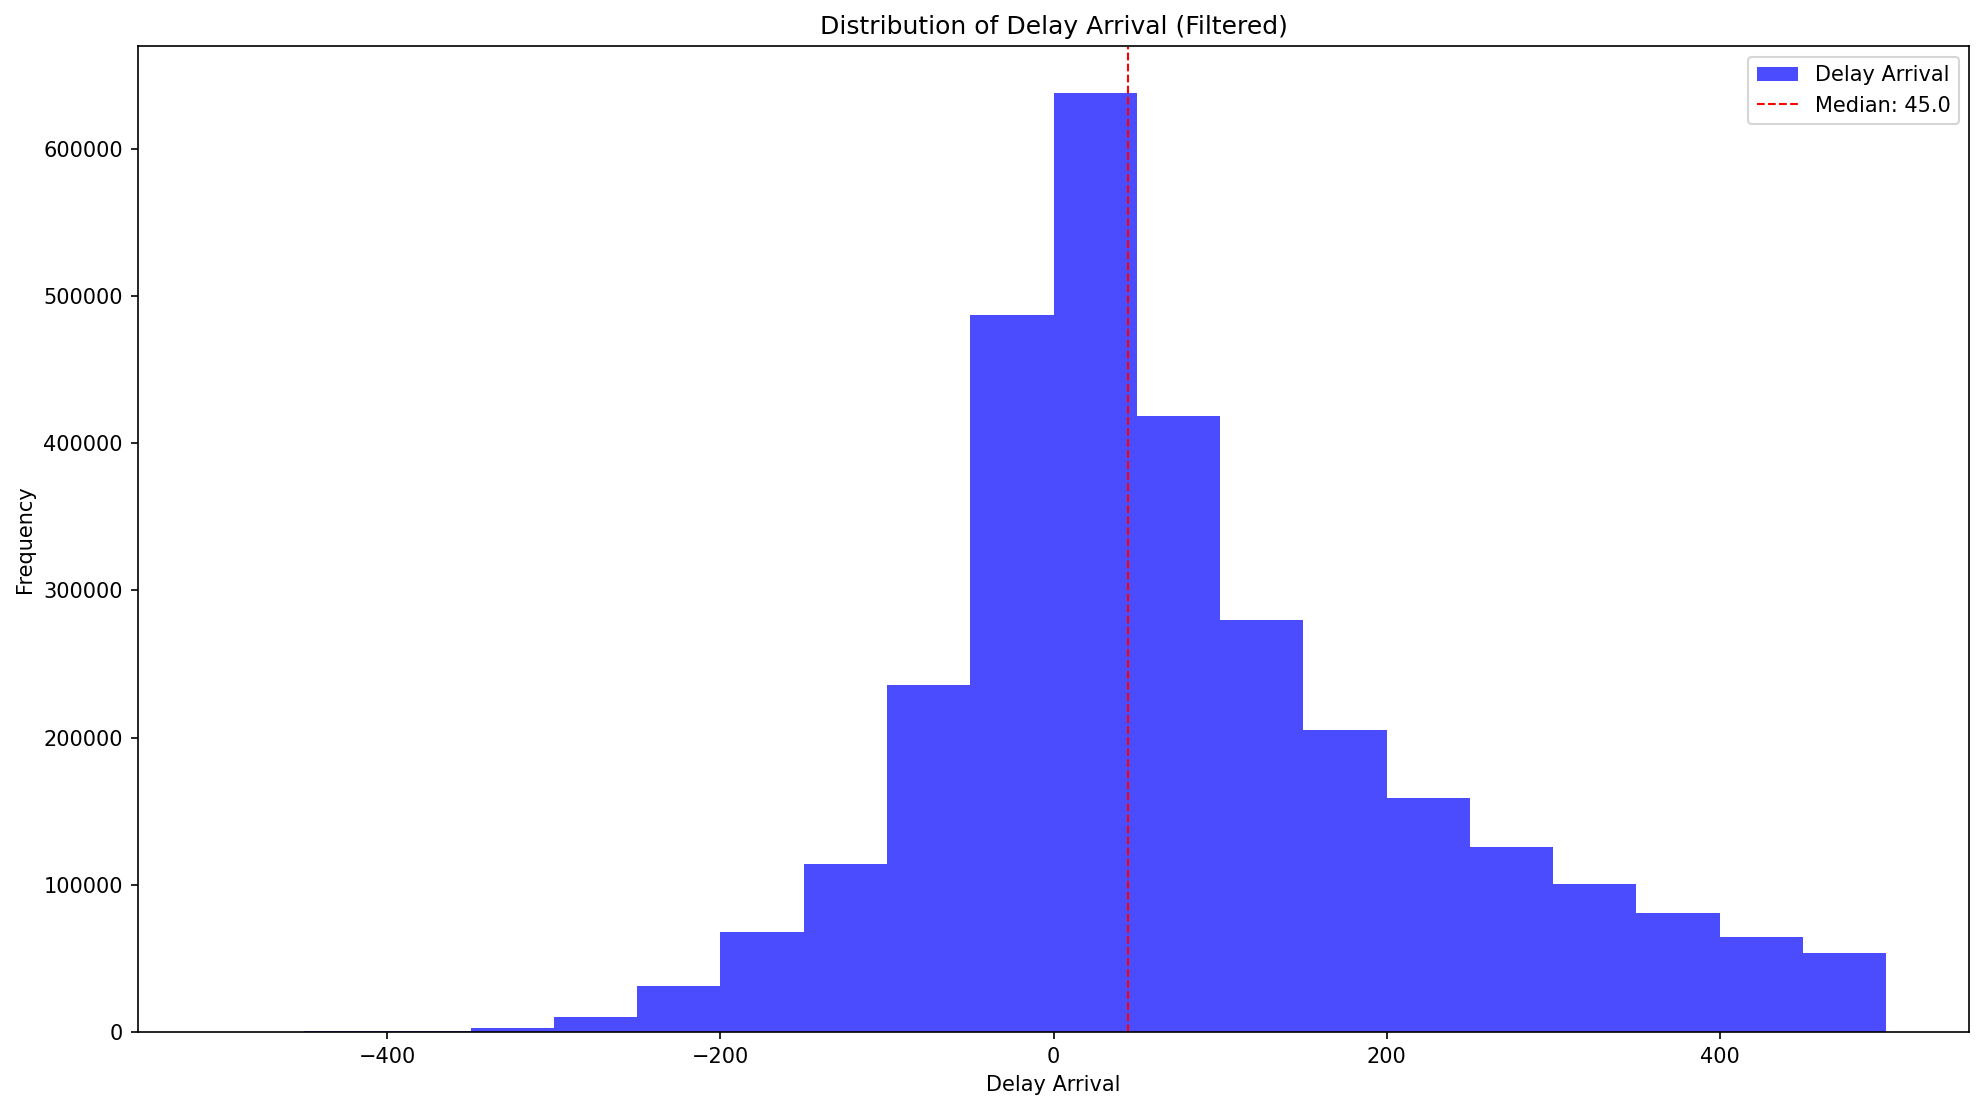

In [30]:
filtered = line[(line['delay_arrival'] >= -500) & (line['delay_arrival'] <= 500)]

fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
ax.hist(filtered['delay_arrival'], bins=20, color='blue', alpha=0.7, label='Delay Arrival')
ax.axvline(filtered['delay_arrival'].median(), color='red', linestyle='dashed', linewidth=1, label='Median: ' + str(round(filtered['delay_arrival'].median(), 2)))
ax.set_xlabel('Delay Arrival')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Delay Arrival (Filtered)')
ax.legend()
plt.tight_layout()
plt.show()

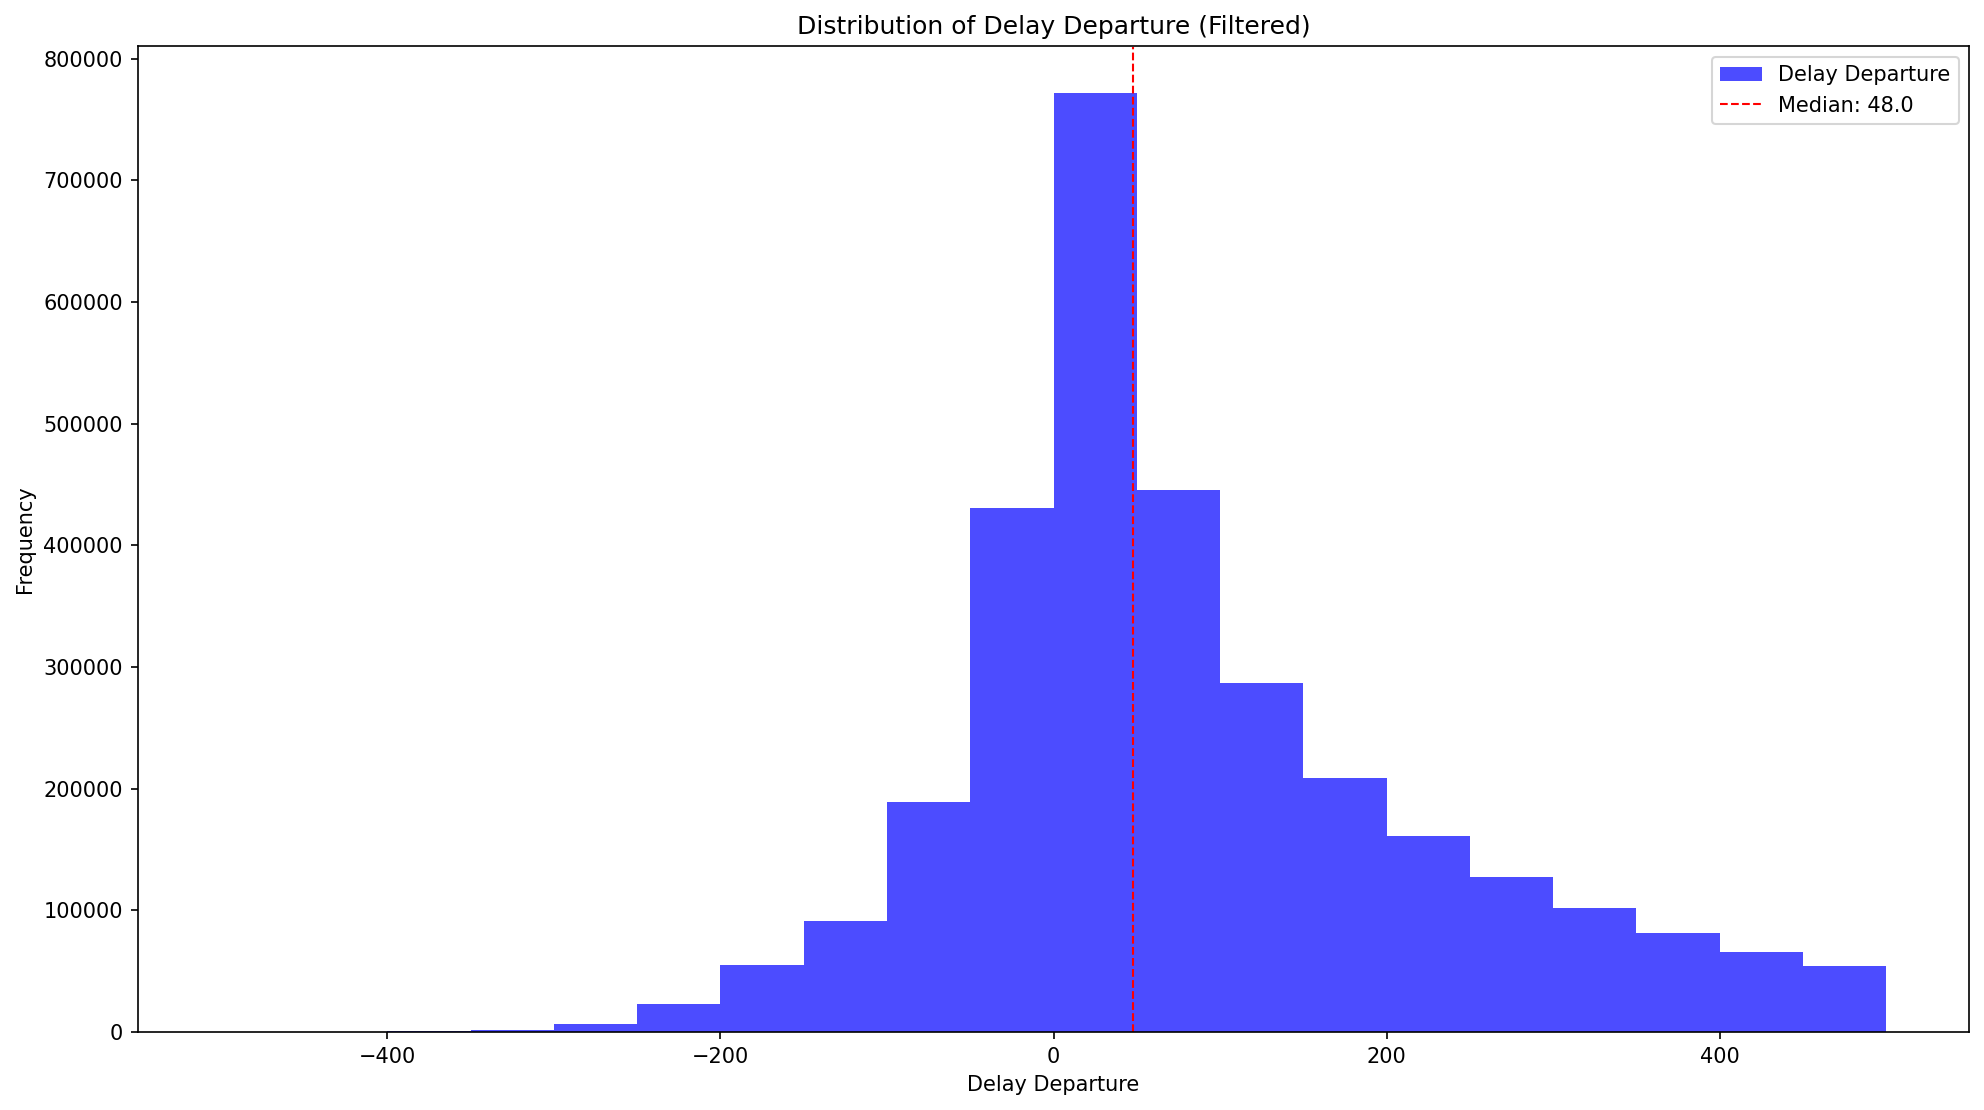

In [29]:
filtered = line[(line['delay_departure'] >= -500) & (line['delay_departure'] <= 500)]
fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
ax.hist(filtered['delay_departure'], bins=20, color='blue', alpha=0.7, label='Delay Departure')
ax.axvline(filtered['delay_departure'].median(), color='red', linestyle='dashed', linewidth=1, label='Median: ' + str(round(filtered['delay_departure'].median(), 2)))
ax.set_xlabel('Delay Departure')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Delay Departure (Filtered)')
ax.legend()
plt.tight_layout()
plt.show()

            ptcar_name  avg_delay_departure
0            OTTIGNIES                118.0
1             MARBEHAN                109.0
2          RHISNES-SAS                106.0
3             BLANMONT                104.0
4      BRUSSEL-SCHUMAN                104.0
5   MONT-SAINT-GUIBERT                101.0
6              CHASTRE                 97.0
7  SAINT-DENIS-BOVESSE                 97.0
8              LEIGNON                 96.0
9               ERNAGE                 96.0


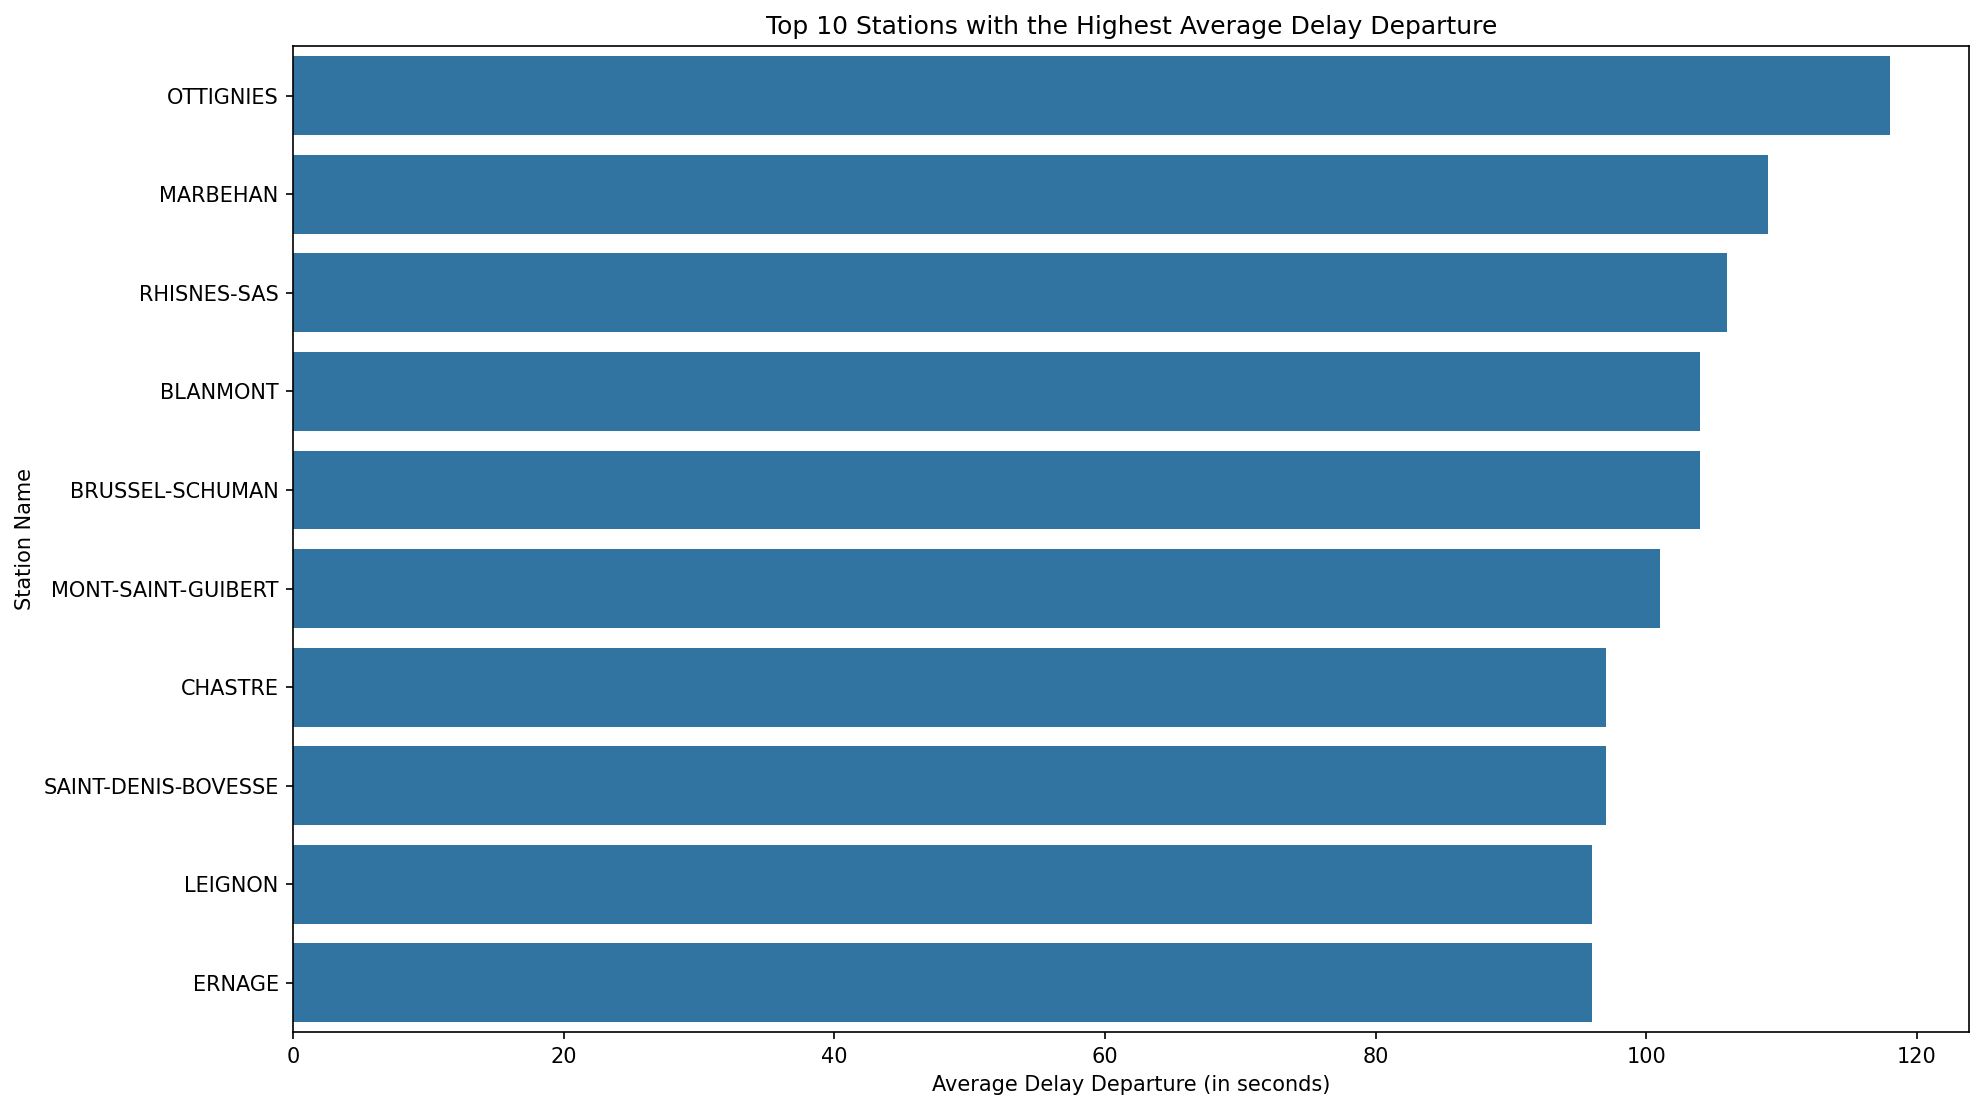

In [ ]:
without_na = line.dropna(subset=["delay_departure"])
ptcar_counts = without_na["ptcar_name"].value_counts()
valid_ptcars = ptcar_counts[ptcar_counts > 10_000].index
without_na = without_na[without_na["ptcar_name"].isin(valid_ptcars)]


top_delay_stations = (without_na.groupby("ptcar_name")["delay_departure"].median().sort_values(ascending=False).head(10).reset_index())

top_delay_stations.columns = ["ptcar_name", "avg_delay_departure"]
print(top_delay_stations)

fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
sns.barplot(data=top_delay_stations, x="avg_delay_departure", y="ptcar_name")
plt.xlabel("Average Delay Departure (in seconds)")
plt.ylabel("Station Name")
plt.title("Top 10 Stations with the Highest Average Delay Departure")
plt.tight_layout()


    ptcar_name  pct_late_departure
0      JEMELLE           27.481522
1     MARBEHAN           26.303610
2      VIVILLE           24.829843
3      LEIGNON           24.620682
4    FORRIERES           24.168675
5  RHISNES-SAS           24.082422
6        CINEY           24.046336
7      GRUPONT           23.890986
8    OTTIGNIES           23.696874
9      STOCKEM           23.691585


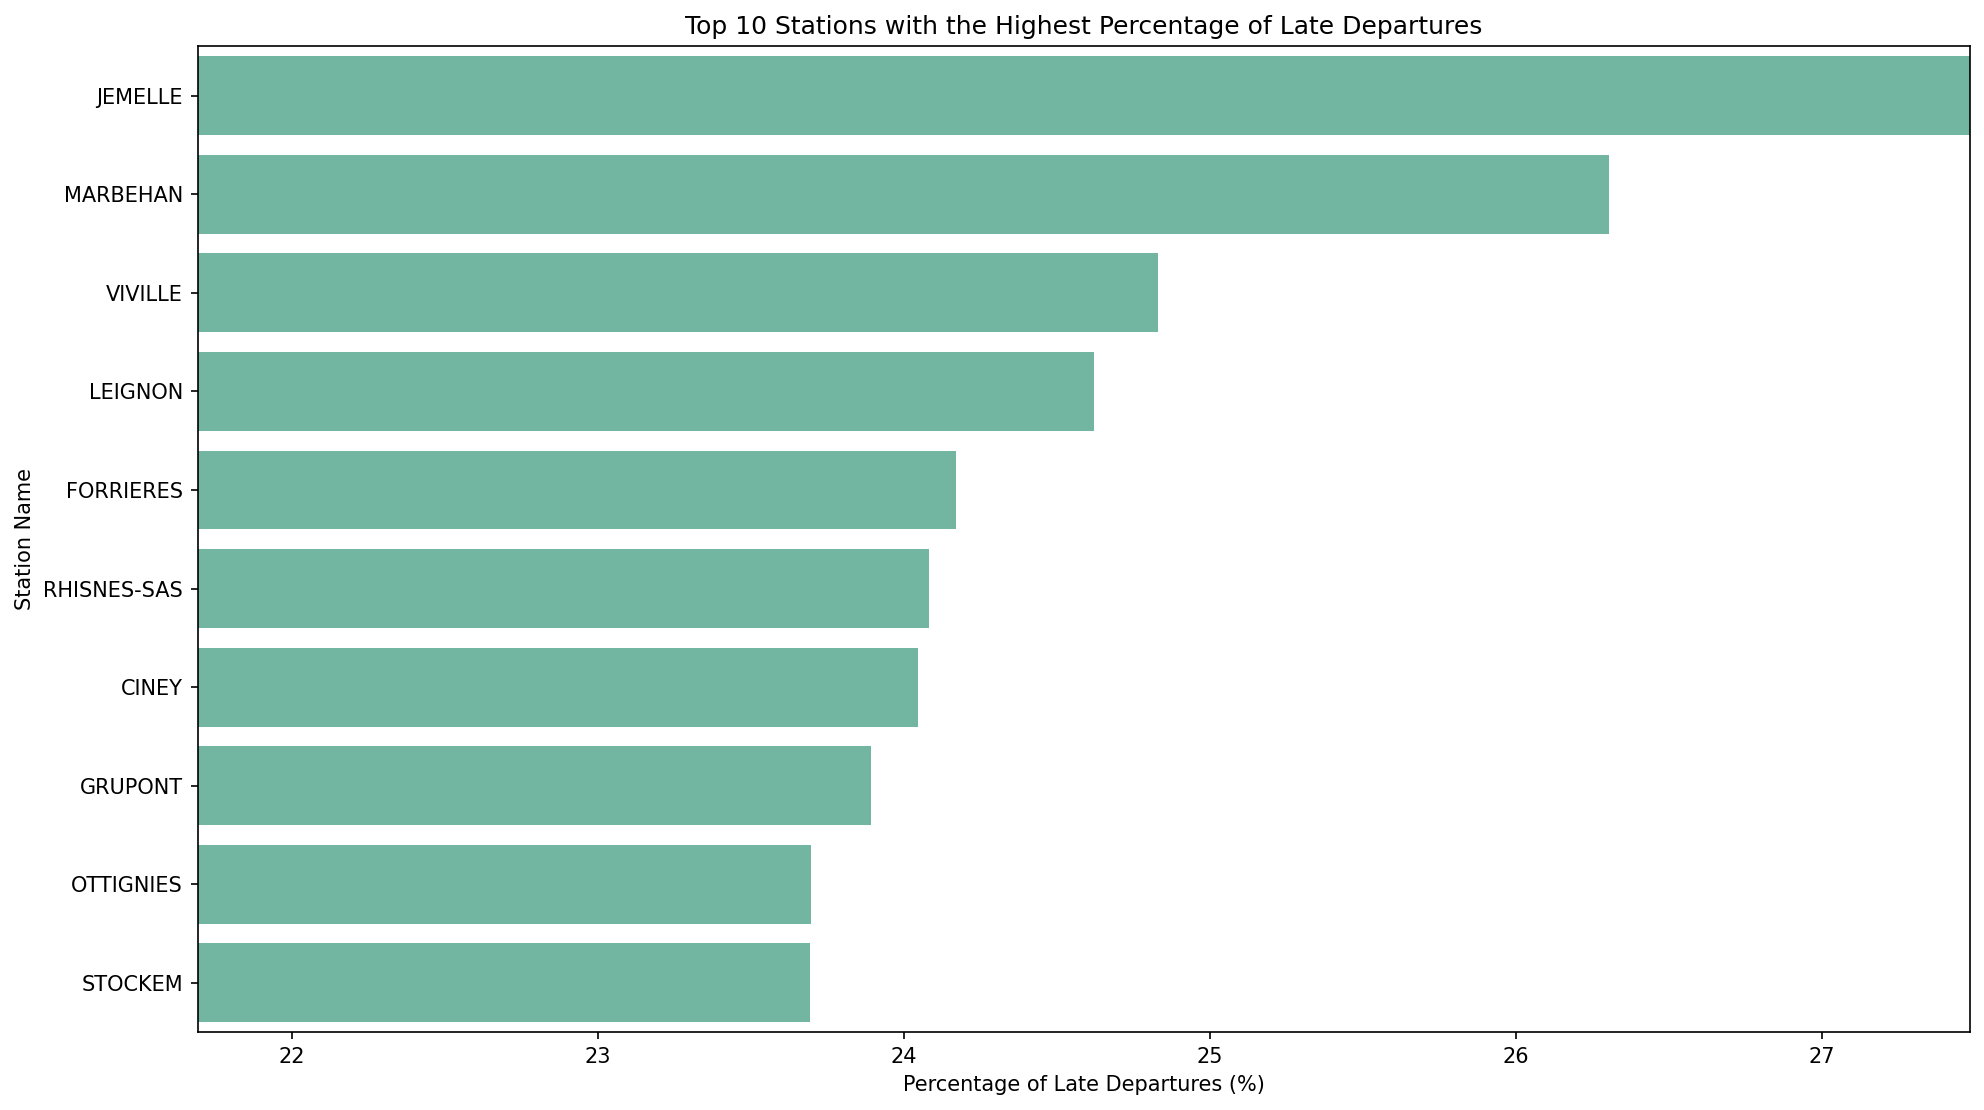

In [27]:
without_na = line.dropna(subset=["delay_departure"])

ptcar_counts = without_na["ptcar_name"].value_counts()
valid_ptcars = ptcar_counts[ptcar_counts > 10_000].index
without_na = without_na[without_na["ptcar_name"].isin(valid_ptcars)]

without_na["is_late"] = without_na["delay_departure"] > 300

delay_ratio = (
    without_na.groupby("ptcar_name")["is_late"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

delay_ratio.columns = ["ptcar_name", "pct_late_departure"]
delay_ratio["pct_late_departure"] *= 100  
print(delay_ratio)

fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
sns.barplot(data=delay_ratio, x="pct_late_departure", y="ptcar_name", palette="Set2", hue=1, legend=False)
plt.xlabel("Percentage of Late Departures (%)")
plt.ylabel("Station Name")
plt.title("Top 10 Stations with the Highest Percentage of Late Departures")
plt.xlim(delay_ratio["pct_late_departure"].min() -2, delay_ratio["pct_late_departure"].max())
plt.tight_layout()
plt.show()

In [ ]:
road = [159,151,149,150,156,157,154,245,773,132,310,365,422,300,628,614,591,
 540,118,178,235,281,480,108,642,624,623,557,558,384,199,559,645,195,73,
 261,560,187,438,172,342,341,80,503,388,267,313,608,339,452,564,493,
 317,704,757,70]

print("Road:", len(road))

tempo = []
clean = []
road_index = 0

for i, row in line.iterrows():
    ptcar_id = row['ptcar_id']
    if ptcar_id == road[road_index]:
        tempo.append(row)
        road_index += 1
        if len(tempo) == len(road):
            clean.extend(tempo)
            tempo = []
            road_index = 0
    else:
        tempo = []
        road_index = 0

clean_df = pd.DataFrame(clean)

print(len(clean_df))
print(clean_df.head())



Road: 56
226632
         id departure_date  train_number  ptcar_number line_number_departure  \
4  24603918     2014-12-14          2108           220                   0/3   
5  24603919     2014-12-14          2108           217                   0/3   
6  24603920     2014-12-14          2108           215                   0/3   
7  24603921     2014-12-14          2108           216                   0/3   
8  24603922     2014-12-14          2108           221                 161/2   

  real_time_arrival real_time_departure planned_time_arrival  \
4              None            08:45:07                 None   
5          08:47:32            08:47:09             08:35:00   
6          08:48:14            08:49:21             08:36:00   
7          08:50:47            08:50:43             08:39:00   
8          08:52:53            08:54:25             08:41:00   

  planned_time_departure  delay_arrival  delay_departure  ptcar_id  \
4               08:33:00            0.0         